# 3.1 MNIST

In [1]:
from sklearn.datasets import fetch_openml
mnist = fetch_openml('mnist_784',version=1)
mnist.keys()

dict_keys(['data', 'target', 'frame', 'feature_names', 'target_names', 'DESCR', 'details', 'categories', 'url'])

사이킷런에서 읽어드린 데이터셋들은 일반적으로 비슷한 딕셔너리 구조를 가지고 있다.
- 데이터셋을 설명하는 DESCR키
- 샘플이 하나의 행, 특성이 하나의 열로 구성된 배열을 가진 data키
- 레이블 배열을 담은 target키

In [2]:
X, y = mnist["data"], mnist["target"]
X.shape

(70000, 784)

In [3]:
y.shape

(70000,)

28x28 픽셀 이미지라서 70,000의 이미지와 각 이미지 마다 784의 특성이 있다.

개개의 특성은 0(흰색)부터 255(검은색)까지의 픽셀 강도를 나타낸다.

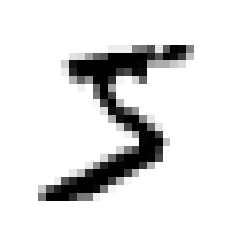

In [4]:
import matplotlib as mpl
import matplotlib.pyplot as plt

some_digit = X[0]
some_digit_image = some_digit.reshape(28, 28)
plt.imshow(some_digit_image, cmap=mpl.cm.binary)
plt.axis("off")
plt.show()

In [5]:
y[0]

'5'

레이블은 문자열이다. 머신러닝 알고리즘은 숫자를 기대하므로 y를 정수로 변환한다.

In [6]:
import numpy as np
y = y.astype(np.uint8)

MNIST추출

In [7]:
# 숫자 그림을 위한 추가 함수
def plot_digits(instances, images_per_row=10, **options):
    size = 28
    images_per_row = min(len(instances), images_per_row)
    images = [instance.reshape(size,size) for instance in instances]
    n_rows = (len(instances) - 1) // images_per_row + 1
    row_images = []
    n_empty = n_rows * images_per_row - len(instances)
    images.append(np.zeros((size, size * n_empty)))
    for row in range(n_rows):
        rimages = images[row * images_per_row : (row + 1) * images_per_row]
        row_images.append(np.concatenate(rimages, axis=1))
    image = np.concatenate(row_images, axis=0)
    plt.imshow(image, cmap = mpl.cm.binary, **options)
    plt.axis("off")

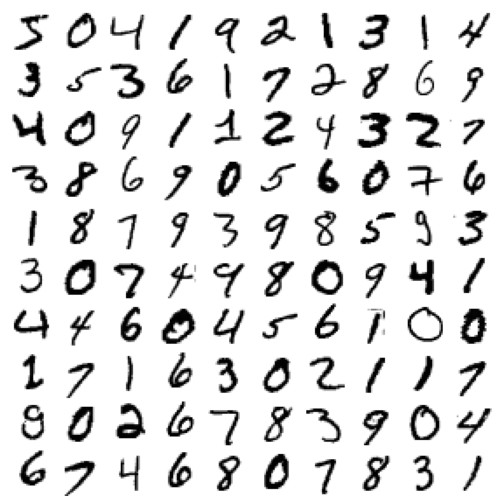

In [8]:
plt.figure(figsize=(9,9))
example_images = X[:100]
plot_digits(example_images, images_per_row=10)
plt.show()

train셋과 test셋을 나눠놓는다.

In [9]:
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

# 3.2 이진 분류기 훈련

숫자 5만 식별하는 분류기를 만든다. 

'5'와 '5가 아님' 두개의 클래스를 구분할 수 있는 이진분류기의 예이다.

분류 작업을 위해 타긴 벡터를 만든다.

In [10]:
y_train_5 = (y_train == 5) # 5 = True, 다른 숫자는 모두 False
y_test_5 = (y_test == 5)

확률적 경사하강법 분류기를 사용한다. 매우 큰 데이터셋을 효율적으로 처리하는 장점이 있다. SGD가 한 번에 하나씩 훈련 샘플을 독립적으로 처리한다.
> SFDClassifier는 훈련하는데 무작위성을 사용한다(그래서 '확률적'이라는 말이 붙는다)

> 결과를 재현하고 싶다면 random_state매개변수를 지정해야한다.

In [13]:
from sklearn.linear_model import SGDClassifier

sgd_clf = SGDClassifier(max_iter=1000, tol=1e-3, random_state=42)
sgd_clf.fit(X_train, y_train_5)

SGDClassifier(alpha=0.0001, average=False, class_weight=None,
              early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
              l1_ratio=0.15, learning_rate='optimal', loss='hinge',
              max_iter=1000, n_iter_no_change=5, n_jobs=None, penalty='l2',
              power_t=0.5, random_state=42, shuffle=True, tol=0.001,
              validation_fraction=0.1, verbose=0, warm_start=False)

In [14]:
sgd_clf.predict([some_digit])

array([ True])

# 3.3 성능측정

## 3.3.1 교차검증을 사용한 정확도 측정

교차검증구현

- StratifiedKFold는 클래스별 비율이 유지되도록 폴드를 만들기 위해 계층적 샘플링을 수행한다.
- 매 반복에서 분류기 객체를 복제하여 훈련 폴드로 훈련시키고 테스트 폴드로 예측을 만든다.
- 올바른 예측의 수를 세어 정확한 예측의 비율을 출력한다.


In [15]:
from sklearn.model_selection import StratifiedKFold
from sklearn.base import clone # 모델을 복사하기 위해 사용

# shuffle=False가 기본값이기 때문에 random_state를 삭제하던지 shuffle=True로 지정하라는 경고가 발생합니다.
# 0.24버전부터는 에러가 발생할 예정이므로 향후 버전을 위해 shuffle=True을 지정합니다.
skfolds = StratifiedKFold(n_splits=3, random_state=42, shuffle=True)

for train_index, test_index in skfolds.split(X_train, y_train_5):
    clone_clf = clone(sgd_clf)
    X_train_folds = X_train[train_index]
    y_train_folds = y_train_5[train_index]
    X_test_fold = X_train[test_index]
    y_test_fold = y_train_5[test_index]

    clone_clf.fit(X_train_folds, y_train_folds)
    y_pred = clone_clf.predict(X_test_fold)
    n_correct = sum(y_pred == y_test_fold)
    print(n_correct / len(y_pred))

0.9669
0.91625
0.96785


croos_val_score()함수로 폴드가 3개인 k-겹 교차 검증을 사용하여 모델을 평가했다.

k-겹 교차 검증은 훈련 세트를 k개의 폴드로 나누고, 각 폴드에 대해 예측을 만들고 평가하기 위해 나머지 폴드로 훈련시킨 모델을 사용한다.

In [16]:
from sklearn.model_selection import cross_val_score
cross_val_score(sgd_clf,X_train,y_train_5,cv=3,scoring='accuracy')

array([0.95035, 0.96035, 0.9604 ])

In [17]:
from sklearn.base import BaseEstimator
class Never5Classifier(BaseEstimator):
    def fit(self, X, y=None):
        pass
    def predict(self, X):
        return np.zeros((len(X), 1), dtype=bool)

In [18]:
never_5_clf = Never5Classifier()
cross_val_score(never_5_clf, X_train, y_train_5, cv=3, scoring="accuracy")

array([0.91125, 0.90855, 0.90915])

## 3.3.2 오차 행렬

클래스 A의 샘플 이 클래스 B로 분류된 횟수를 세는 것이다. 테스트 세트로 예측을 만들수 있지만 여기서는 사용하면 안된다. 대신 cross_val_predict()을 사용할수 있다.

In [19]:
from sklearn.model_selection import cross_val_predict

y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3)

- cross_val_score()함수처럼 cross_val_predic()함수는 k-겹 교차 검증을 수행하지만 평가 점수를 반환하지 않고 각 테스트 폴드에서 얻은 예측을 반환한다. 
- 즉 훈련 세트의 모든 샘플에 대해 깨끗한 예측을 얻게 된다.

confusion_maxtrix()함수로 오차행렬을 만든다. 타겟 클래스와 예측 클래스를 넣고 호출한다.

In [20]:
from sklearn.metrics import confusion_matrix

confusion_matrix(y_train_5, y_train_pred)

array([[53892,   687],
       [ 1891,  3530]])

오차 행렬의 행은 실제 클래스를 나타내고 열은 예측한 클래스를 나타낸다.

완벽한 분류기라면 진짜 양성과 진짜 음성만 가지고 있을것이므로 오차행렬의 주대각선(왼쪽 위에서 오른쪽 아래)만 0이 아닌 값이 된다.

In [21]:
y_train_perfect_predictions = y_train_5  # 완벽한 분류기일 경우
confusion_matrix(y_train_5, y_train_perfect_predictions)

array([[54579,     0],
       [    0,  5421]])

- 정밀도 precision
> TP = 진짜 양성수
> FP = 거짓 양성수

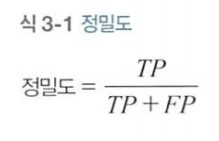

- 재현율 recall
> FN = 거짓 음성수

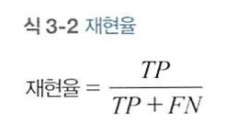

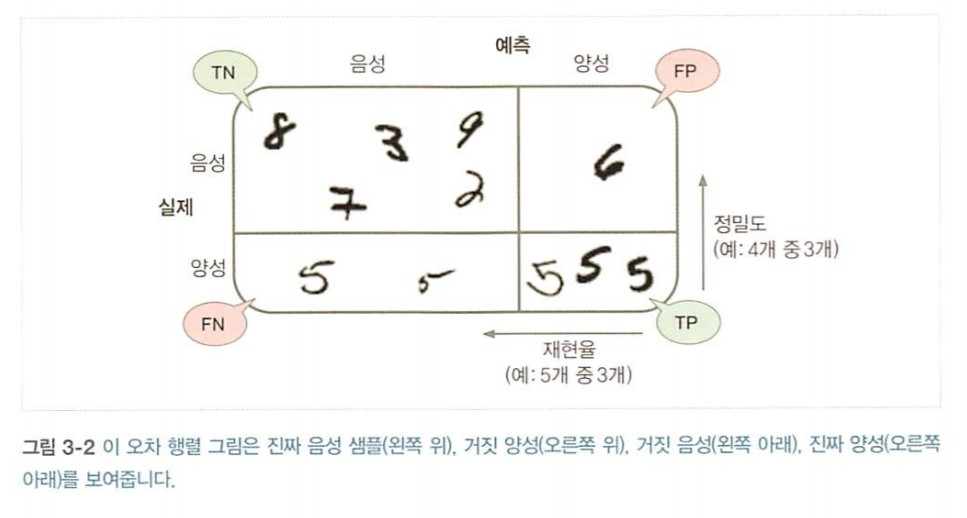

## 3.3.3 정밀도와 재현율

사이킷런은 정밀도와 재현율을 포함하여 분류기의 지표 계산 함수를 제공한다.

In [22]:
from sklearn.metrics import precision_score, recall_score

precision_score(y_train_5, y_train_pred)
# 3530 / (3530 + 687)

0.8370879772350012

In [23]:
recall_score(y_train_5, y_train_pred)
#3530 / (3530 + 1891)

0.6511713705958311

정밀도와 재현율을 F1-score로 만들면 편리하다. 정밀도와 재현율의 조화 평균이다.

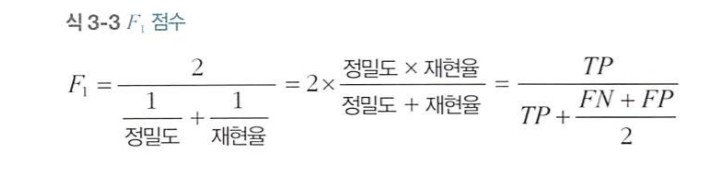

In [24]:
from sklearn.metrics import f1_score

f1_score(y_train_5, y_train_pred)

0.7325171197343846

정밀도를 올리면 재현율이 줄고 그 반대도 마찬가지이다. 이를 정밀도/재현율 트레이드오프라고 부른다.

---



## 3.3.4 정밀도/재현율 트레이드오프

1. SGDClassifier 분류기는 결정함수를 사용하여 각 샘플의 점수를 계산한다. 
2. 점수가 임곗값보다 크면 양성으로 작으면 음성으로 할당한다.

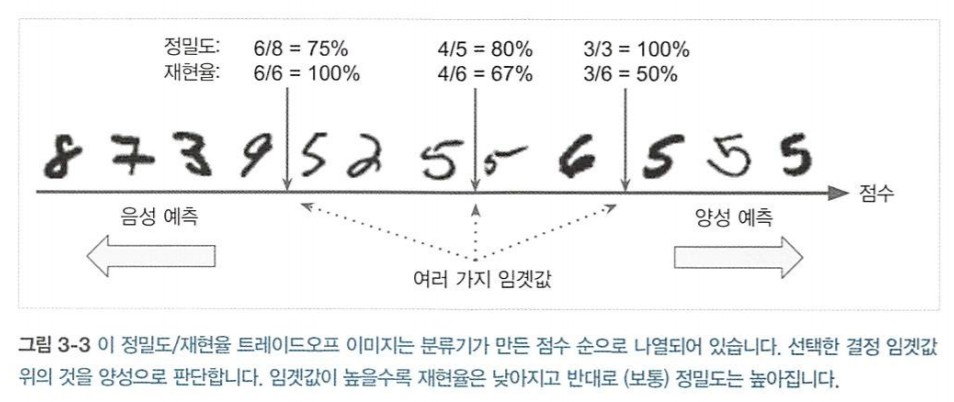

사이킷런에서 임계값을 직접 지정할 수는 없지만 예측에 사용한 점수는 확인할 수 있다. predict() 대신 decision_function() 메서드를 호출하면 각 샘플의 점수를 얻을 수 있다.

In [25]:
y_scores = sgd_clf.decision_function([some_digit])
y_scores

array([2164.22030239])

In [26]:
threshold = 0
y_some_digit_pred = (y_scores > threshold)
y_some_digit_pred

array([ True])

- 임계값이 0 이므로 True를 반환한다.

In [27]:
threshold = 8000
y_some_digit_pred = (y_scores > threshold)
y_some_digit_pred

array([False])

- 임계값을 높이면 재현율이 줄어든다는 것을 보여준다.

적절한 임계값을 구하기 위해 cross_val_predict()를 사용하여 훈련 세트에 있는 모든 샘플의 점수를 구해야한다.

지금은 예측 결과가 아니라 결정점수를 반환하도록 지정한다.

In [28]:
y_scores = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3,
                             method="decision_function")

precision_recall_curve() 함수를 사용하여 가능한 모든 임곗값에 대해 정밀도와 재현율은 계산할수있다.

In [29]:
from sklearn.metrics import precision_recall_curve

precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores)

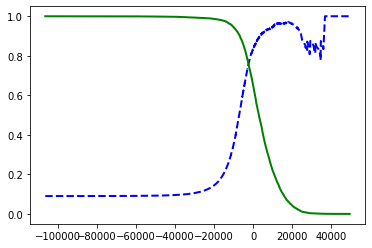

In [30]:
def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], "b--", label="Precision", linewidth=2)
    plt.plot(thresholds, recalls[:-1], "g-", label="Recall", linewidth=2)
    
plot_precision_recall_vs_threshold(precisions, recalls, thresholds)

plt.show()

좋은 트레이드오프를 선택하는 방법은 재현율에 대한 정밀도 곡선을 그리는 것이다.

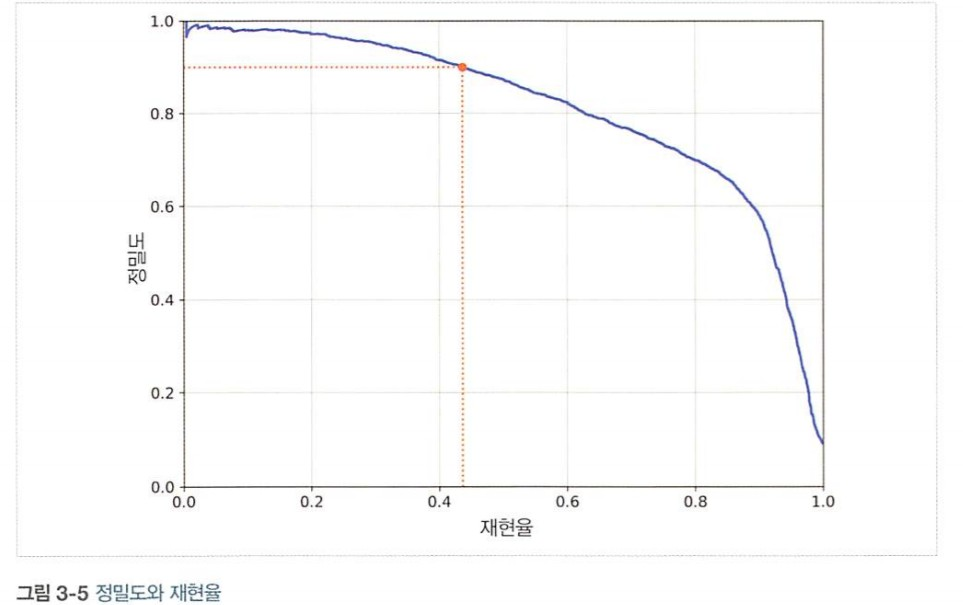

1. 재현율 80% 근처에서 정밀도가 급격히 줄어든다. 이 지점을 트레이드 오프로 선택하는 것이 좋다.

정밀도 90%를 기준으로 할때 임곗값이 약 8,000 정도다.

최소한 90% 정밀도가 되는 가장 낮은 임계값을 찾을 수 있다.

np.argmax()는 최댓값의 첫 번째 인덱스를 반환한다.

In [31]:
threshold_90_precision = thresholds[np.argmax(precisions >= 0.90)] 
#스레쉬홀드 = 임계값 이진분류에서 참 거짓을 나누는 기준
threshold_90_precision

3370.0194991439557

훈련에 대한 예측을 만드려면 predict() 대신 다음 코드를 실행한다

In [32]:
y_train_pred_90 = (y_scores >= threshold_90_precision)
precision_score(y_train_5, y_train_pred_90)

0.9000345901072293

In [33]:
recall_score(y_train_5, y_train_pred_90)

0.4799852425751706

## 3.3.5 ROC 곡선

1. 수신기 조작 특성(ROC)곡선도 이진분류에서 널리 사양되는 도구다.
2. 거짓양성비율(FPR)에 대한 진짜 양성비율(TPR)의 곡선이다.
3. 양성으로 잘못 분류된 음성 샘플의 비율이 FPR이다. 이는 1 에서 음성으로 정확하게 분류된 진짜음성비율을 뺀 값이다.
4. ROC곡선은 민감도(재현율)에 대한 1-특이도 그래프다.

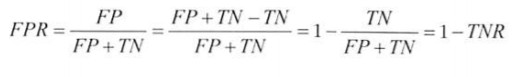

ROC 곡선을 그리려면 먼저 roc_curver() 함수를 사용한다.

In [34]:
from sklearn.metrics import roc_curve

fpr, tpr, thresholds = roc_curve(y_train_5, y_scores)

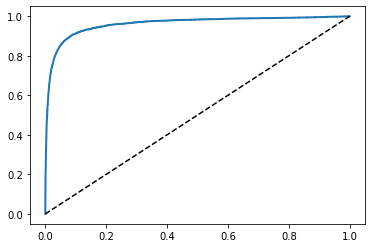

In [35]:
def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], 'k--') # 대각 점선
plot_roc_curve(fpr, tpr)
plt.show()

1. 여기에도 트레이드오프가 있다.
2. 재현율(TPR)이 높을수록 분류기가 만드는 거짓 양성(FPR)이 늘어난다.
3. 점선은 완전한 랜덤 분류기의 ROC곡선을 뜻한다.
4. 좋은 분류기는 점선에서 멀어질수록 좋다.

1. 곡선 아래의 면적(AUC)을 측정하면 분류기들을 비교할수있다.
2. 완벽한 분류기은 ROC의 AUC가 1이고 완전 랜덤 분류기는 0.5다.

In [36]:
from sklearn.metrics import roc_auc_score

roc_auc_score(y_train_5, y_scores)

0.9604938554008616

1. RandomForestClassifier를 훈련시켜 SGDClassifier의 ROC AUC 점수를 비교한다.
2. 훈련 세트의 샘플에 대한 점수를 얻어야 한다.
3. decision_function() 메서드가 없어서 predict_proba()를 사용한다.
4. predict_proba() 메서드는 샘플이 행, 클래스가 열이고 샘플이 주어진 클래스에 속할 확률을 담은 배열을 반환한다.

In [37]:
from sklearn.ensemble import RandomForestClassifier
forest_clf = RandomForestClassifier(n_estimators=100, random_state=42)
y_probas_forest = cross_val_predict(forest_clf, X_train, y_train_5, cv=3,
                                    method="predict_proba")

roc_curve()함수는 레이블과 점수를 기대한다.

In [38]:
y_scores_forest = y_probas_forest[:, 1] # 점수 = 양성 클래스의 확률
fpr_forest, tpr_forest, thresholds_forest = roc_curve(y_train_5,y_scores_forest)

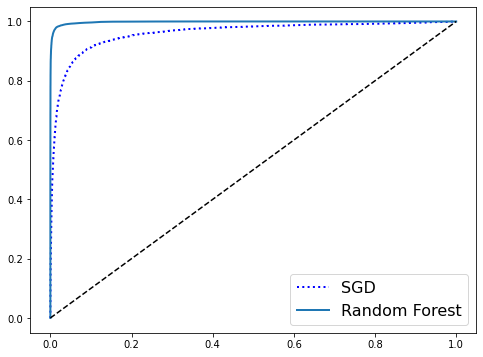

In [39]:
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, "b:", linewidth=2, label="SGD")
plot_roc_curve(fpr_forest, tpr_forest, "Random Forest")
plt.legend(loc="lower right", fontsize=16)
plt.show()

RandomForestClassifier이 왼쪽 위 모서리에 더 가까워서 좋아보인다.

In [40]:
roc_auc_score(y_train_5, y_scores_forest)

0.9983436731328145

## 3.4 다중분류

- 다중 분류기는 둘 이상의 클래스를 구별할 수 있다.
- 이진 분류기를 여러개 사용해 다중 클래스를 분류하는 기법도 있다.
- OvR(OvA)는 클래스 갯수만큼 이진분류를 한다.
- OvO 는 각 조합마다 이진 분류를 한다.
- 대부분의 이진 분류 알고리즘에는 OvR을 선호한다.

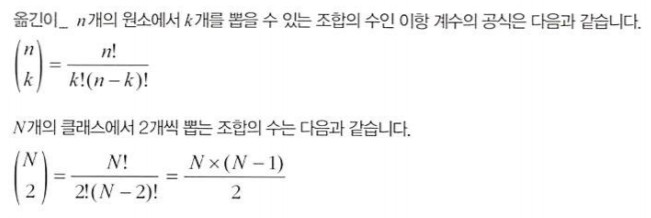

In [41]:
from sklearn.svm import SVC

svm_clf = SVC(gamma="auto", random_state=42)
svm_clf.fit(X_train[:1000], y_train[:1000]) # y_train_5이 아니라 y_train입니다
svm_clf.predict([some_digit])

array([5], dtype=uint8)

1. 이 코드는 5를 구별한 타깃 클래스 대신 0에서 9까지으 ㅣ원래 타깃클래스를 사용해 SVC를 훈련 시킨다.
2. 내부에서는 사이킷런이 OvO전략을 사용해 10개의 이진 분류기를 훈련시키고 각각의 결정 점수를 더어 점수가 가장 높은 클래스를 선택한다.

In [42]:
some_digit_scores = svm_clf.decision_function([some_digit])
some_digit_scores

array([[ 2.81585438,  7.09167958,  3.82972099,  0.79365551,  5.8885703 ,
         9.29718395,  1.79862509,  8.10392157, -0.228207  ,  4.83753243]])

In [43]:
np.argmax(some_digit_scores)

5

In [44]:
svm_clf.classes_

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=uint8)

In [45]:
svm_clf.classes_[5] #이런경우는 드물다.

5

사이킷런에서 OvO나 OvR을 사용하도록 강제하려면 OneVsOneClassifier나 OneVsRestClassifier를 사용한다.

In [46]:
from sklearn.multiclass import OneVsRestClassifier
ovr_clf = OneVsRestClassifier(SVC(gamma="auto", random_state=42))
ovr_clf.fit(X_train[:1000], y_train[:1000])
ovr_clf.predict([some_digit])

array([5], dtype=uint8)

In [47]:
len(ovr_clf.estimators_)

10

SGDClassifier 훈련

In [48]:
sgd_clf.fit(X_train, y_train)
sgd_clf.predict([some_digit])

array([3], dtype=uint8)

이 경우 SGD 분류기는 직접 샘플을 다중 클래스로 분류할 수 있기 때문에 별도로 사잇키런의 OvR이나 OvO를 적용할 필요가 없다. 

decision_function()메서드는 클래스마다 하나의 값을 반환한다.

In [49]:
sgd_clf.decision_function([some_digit])

array([[-31893.03095419, -34419.69069632,  -9530.63950739,
          1823.73154031, -22320.14822878,  -1385.80478895,
        -26188.91070951, -16147.51323997,  -4604.35491274,
        -12050.767298  ]])

분류기 평가에는 일반적으로 교차 검증을 사용한다.

In [50]:
cross_val_score(sgd_clf, X_train, y_train, cv=3, scoring="accuracy")

array([0.87365, 0.85835, 0.8689 ])

In [51]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train.astype(np.float64))
cross_val_score(sgd_clf, X_train_scaled, y_train, cv=3, scoring="accuracy")

array([0.8983, 0.891 , 0.9018])

# 3.5 에러 분석

모델의 성능을 향상시키는 방법중 하나는 에러의 종류를 분석하는 것이다.

In [52]:
y_train_pred = cross_val_predict(sgd_clf, X_train_scaled, y_train, cv=3) # 예측값 만들기
conf_mx = confusion_matrix(y_train, y_train_pred) # 함수 생성 호출
conf_mx

array([[5577,    0,   22,    5,    8,   43,   36,    6,  225,    1],
       [   0, 6400,   37,   24,    4,   44,    4,    7,  212,   10],
       [  27,   27, 5220,   92,   73,   27,   67,   36,  378,   11],
       [  22,   17,  117, 5227,    2,  203,   27,   40,  403,   73],
       [  12,   14,   41,    9, 5182,   12,   34,   27,  347,  164],
       [  27,   15,   30,  168,   53, 4444,   75,   14,  535,   60],
       [  30,   15,   42,    3,   44,   97, 5552,    3,  131,    1],
       [  21,   10,   51,   30,   49,   12,    3, 5684,  195,  210],
       [  17,   63,   48,   86,    3,  126,   25,   10, 5429,   44],
       [  25,   18,   30,   64,  118,   36,    1,  179,  371, 5107]])

In [53]:
def plot_confusion_matrix(matrix):
    """If you prefer color and a colorbar"""
    fig = plt.figure(figsize=(8,8))
    ax = fig.add_subplot(111)
    cax = ax.matshow(matrix)
    fig.colorbar(cax)

함수를 이미지로 표현

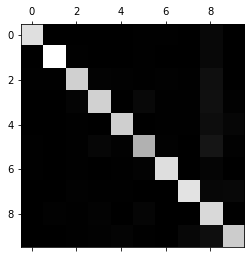

In [55]:
plt.matshow(conf_mx, cmap=plt.cm.gray)
plt.show()

1. 이미지가 올바르게 분류되었음을 나타내는 주대각선에 있어서 매우 좋아 보인다.

2. 숫자 5는 다른 숫자보다 조금 더 어두워 보인다. 데이터셋에 5의 이미지가 적거나 분류기가 5를 다른 숫자만큼 잘 분류하지 못한다는 뜻이다.

오차행렬의 각 값을 대응되는 클래스의 이미지 개수로 나누어 에러 비율을 비교한다.

개수로 비교하면 이미지가 많은 클래스가 상대적으로 나쁘게 보인다.

In [56]:
row_sums = conf_mx.sum(axis=1, keepdims=True)
norm_conf_mx = conf_mx / row_sums

주대각선만 0으로 채워서 그래프를 그린다.

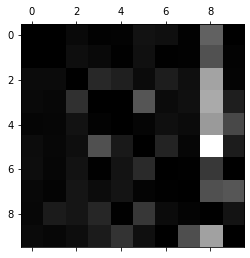

In [57]:
np.fill_diagonal(norm_conf_mx, 0)
plt.matshow(norm_conf_mx, cmap=plt.cm.gray)
plt.show()

1. 행은 실제클래스를 나타내고 열은 예측한 클래스를 나타낸다.
2. 8의 열은 상당이 밝으므로 다수의 이미지가 8로 잘못 분류되었음을 나타낸다.
3. 8의 행은 적절히 어둡다. 이는 실제8이 적절히 8로 분류되었다는 뜻이다.
4. 오차행렬은 반드시 대칭이 아니다.
5. 3과 5가 서로 많이 혼동된다는걸 볼수있다.


- 향상방향은 8로 잘못분류되는 것을 줄이도록 개선 해야한다.

>> 8이아닌 이미지가 8로 보이는 숫자의 훈련데이터를 더 많이 모아서 학습시킨다.

>> 동심원의 수를 세는 알고리즘 또는 어떤 패턴이 드러나도록 이미지를 전처리 한다.

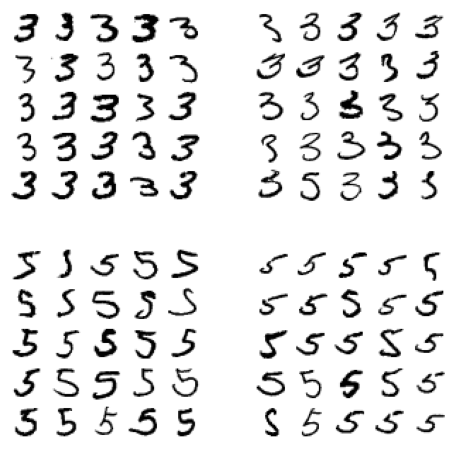

In [59]:
cl_a, cl_b = 3, 5
X_aa = X_train[(y_train == cl_a) & (y_train_pred == cl_a)]
X_ab = X_train[(y_train == cl_a) & (y_train_pred == cl_b)]
X_ba = X_train[(y_train == cl_b) & (y_train_pred == cl_a)]
X_bb = X_train[(y_train == cl_b) & (y_train_pred == cl_b)]

plt.figure(figsize=(8,8))
plt.subplot(221); plot_digits(X_aa[:25], images_per_row=5)
plt.subplot(222); plot_digits(X_ab[:25], images_per_row=5)
plt.subplot(223); plot_digits(X_ba[:25], images_per_row=5)
plt.subplot(224); plot_digits(X_bb[:25], images_per_row=5)
plt.show()

1. 왼쪽 블록 두개는 3으로 분류된 이미지고 오른쪽 두개는 5로 분류된 이미지다.
2. 이미지 에러의 원인은 선형모델인 SGD를 사용했기 때문이다. 
> - 선형분류기는 클래스마다 픽셀에 가중치를 할당하고 새로운 이미지에 대해 단순히 픽셀 강도의 가중치 합을 클래스의 점수로 계산한다. 
>- 따라서 3과 5는 몇개의 픽셀만 다르기 때문에 모델이 쉽게 혼동한다.
3. 3과 5의 주요 차이는 위쪽 선과 아래쪽 호를 이어주는 작은 직선의 위치다.
4. 분류기는 이미지의 위치나 회전 방향에 매우 민감하다. 
5. 3과 5의 에러를 줄이는 한거지 방법은 이미지를 중앙에 위치시키고 회전되어 있지 않도록 전처리 하는것이다.

# 3.6 다중 레이블 분류

분류기가 샘플마다 여러개의 클래스를 출력할 때도 있다.

여러개의 이진 꼬리표를 출력하는 분류 시스템을 다중 레이블 분류 시스템이라 한다.

In [60]:
from sklearn.neighbors import KNeighborsClassifier

# 숫자가 큰값(7,8,9)를 나타낸다.
y_train_large = (y_train >= 7)

# 홀수인지 나타낸다.
y_train_odd = (y_train % 2 == 1)

#각 숫자 이미지에 두 개의 타깃 레이블이 담긴 y_multilabel 배열을 만든다.
y_multilabel = np.c_[y_train_large, y_train_odd]

# KNeighborsClassifier 인스턴스를 만들고 
knn_clf = KNeighborsClassifier()

# 다중 타깃 배열을 사용하여 훈련시킨다
knn_clf.fit(X_train, y_multilabel)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                     weights='uniform')

- 각 숫자 이미지에 두 개의 타깃 레이블이 담긴 y_multilabel 배열을 만든다.

In [61]:
knn_clf.predict([some_digit])

array([[False,  True]])

각 레이블의 f1점수를 구하고 간단하게 평균을 계산한다.

In [ ]:
## cross_val_predict로 예측값을 만들고
# y_train_knn_pred = cross_val_predict(knn_clf, X_train, y_multilabel, cv=3)
## f1점수를 구한다.
# f1_score(y_multilabel, y_train_knn_pred, average="macro")

# 3.7 다중 출력 분류

다중 레이블 분류에서 한 레이블이 다중 클래스가 될 수 있도록 일반화한 것이다.

In [79]:
noise = np.random.randint(0, 100, (len(X_train), 784)) # randit()을 사용하여 픽셀 강도에 잡음을 추가
X_train_mod = X_train + noise
noise = np.random.randint(0, 100, (len(X_test), 784))
X_test_mod = X_test + noise
y_train_mod = X_train
y_test_mod = X_test

In [80]:
knn_clf.fit(X_train_mod, y_train_mod)
clean_digit = knn_clf.predict([X_test_mod[some_index]])
plot_digit(clean_digit)

NameError: ignored

## 2. 데이터 증식

In [ ]:
from scipy.ndimage.interpolation import shift

In [ ]:
def shift_image(image, dx, dy):
    image = image.reshape((28, 28))
    shifted_image = shift(image, [dy, dx], cval=0, mode="constant")
    return shifted_image.reshape([-1])

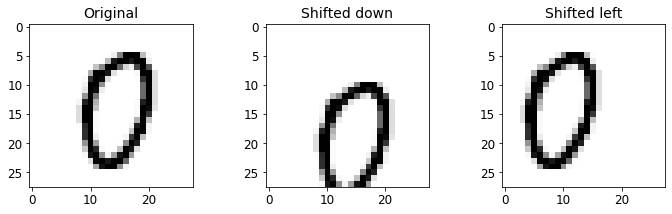

In [ ]:
image = X_train[1000]
shifted_image_down = shift_image(image, 0, 5)
shifted_image_left = shift_image(image, -5, 0)

plt.figure(figsize=(12,3))
plt.subplot(131)
plt.title("Original", fontsize=14)
plt.imshow(image.reshape(28, 28), interpolation="nearest", cmap="Greys")
plt.subplot(132)
plt.title("Shifted down", fontsize=14)
plt.imshow(shifted_image_down.reshape(28, 28), interpolation="nearest", cmap="Greys")
plt.subplot(133)
plt.title("Shifted left", fontsize=14)
plt.imshow(shifted_image_left.reshape(28, 28), interpolation="nearest", cmap="Greys")
plt.show()

In [ ]:
X_train_augmented = [image for image in X_train]
y_train_augmented = [label for label in y_train]

for dx, dy in ((1, 0), (-1, 0), (0, 1), (0, -1)):
    for image, label in zip(X_train, y_train):
        X_train_augmented.append(shift_image(image, dx, dy))
        y_train_augmented.append(label)

X_train_augmented = np.array(X_train_augmented)
y_train_augmented = np.array(y_train_augmented)

In [ ]:
shuffle_idx = np.random.permutation(len(X_train_augmented))
X_train_augmented = X_train_augmented[shuffle_idx]
y_train_augmented = y_train_augmented[shuffle_idx]

In [ ]:
knn_clf = KNeighborsClassifier(**grid_search.best_params_)

In [ ]:
knn_clf.fit(X_train_augmented, y_train_augmented)

KNeighborsClassifier(n_neighbors=4, weights='distance')

In [ ]:
y_pred = knn_clf.predict(X_test)
accuracy_score(y_test, y_pred)

0.9763

간단히 데이터를 증식해서 0.5% 정확도를 높였습니다. :)

## 3. 타이타닉 데이터셋 도전

승객의 나이, 성별, 승객 등급, 승선 위치 같은 속성을 기반으로 하여 승객의 생존 여부를 예측하는 것이 목표입니다.

먼저 [캐글](https://www.kaggle.com)에 로그인 하고 [타이타닉 챌린지](https://www.kaggle.com/c/titanic)에서 `train.csv`와 `test.csv`를 다운로드합니다. 두 파일을 `datasets/titanic` 디렉토리에 저장하세요.

그다음 데이터를 적재합니다:

In [ ]:
import os

TITANIC_PATH = os.path.join("datasets", "titanic")

In [ ]:
import pandas as pd

def load_titanic_data(filename, titanic_path=TITANIC_PATH):
    csv_path = os.path.join(titanic_path, filename)
    return pd.read_csv(csv_path)

In [ ]:
train_data = load_titanic_data("train.csv")
test_data = load_titanic_data("test.csv")

데이터는 이미 훈련 세트와 테스트 세트로 분리되어 있습니다. 그러나 테스트 데이터는 레이블을 가지고 있지 않습니다: 훈련 데이터를 이용하여 가능한 최고의 모델을 만들고 테스트 데이터에 대한 예측을 캐글(Kaggle)에 업로드하여 최종 점수를 확인하는 것이 목표입니다.

훈련 세트에서 맨 위 몇 개의 열을 살펴 보겠습니다:

In [ ]:
train_data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


속성은 다음과 같은 의미를 가집니다:
* **Survived**: 타깃입니다. 0은 생존하지 못한 것이고 1은 생존을 의미합니다.
* **Pclass**: 승객 등급. 1, 2, 3등석.
* **Name**, **Sex**, **Age**: 이름 그대로 의미입니다.
* **SibSp**: 함께 탑승한 형제, 배우자의 수.
* **Parch**: 함께 탑승한 자녀, 부모의 수.
* **Ticket**: 티켓 아이디
* **Fare**: 티켓 요금 (파운드)
* **Cabin**: 객실 번호
* **Embarked**: 승객이 탑승한 곳. C(Cherbourg), Q(Queenstown), S(Southampton)

누락된 데이터가 얼마나 되는지 알아보겠습니다:

In [ ]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       889 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


괜찮네요. **Age**, **Cabin**, **Embarked** 속성의 일부가 null입니다(891개의 non-null 보다 작습니다). 특히 **Cabin**은 77%가 null입니다. 일단 **Cabin**은 무시하고 나머지를 활용하겠습니다. **Age**는 19%가 null이므로 이를 어떻게 처리할지 결정해야 합니다. null을 중간 나이로 바꾸는 것이 괜찮아 보입니다.

**Name**과 **Ticket** 속성도 값을 가지고 있지만 머신러닝 모델이 사용할 수 있는 숫자로 변환하는 것이 조금 까다롭습니다. 그래서 지금은 이 두 속성을 무시하겠습니다.

통계치를 살펴 보겠습니다:

In [ ]:
train_data.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


* 이크, 38%만 **Survived**입니다. :( 거의 40%에 가까우므로 정확도를 사용해 모델을 평가해도 괜찮을 것 같습니다.
* 평균 **Fare**는 32.20 파운드라 그렇게 비싸보이지는 않습니다(아마 요금을 많이 반환해 주었기 때문일 것입니다)
* 평균 **Age**는 30보다 작습니다.

타깃이 0과 1로 이루어졌는지 확인합니다:

In [ ]:
train_data["Survived"].value_counts()

0    549
1    342
Name: Survived, dtype: int64

범주형 특성들을 확인해 보겠습니다:

In [ ]:
train_data["Pclass"].value_counts()

3    491
1    216
2    184
Name: Pclass, dtype: int64

In [ ]:
train_data["Sex"].value_counts()

male      577
female    314
Name: Sex, dtype: int64

In [ ]:
train_data["Embarked"].value_counts()

S    644
C    168
Q     77
Name: Embarked, dtype: int64

**Embarked** 특성은 승객이 탑승한 곳을 알려 줍니다: C=Cherbourg, Q=Queenstown, S=Southampton.

**노트**: 아래 코드는 `Pipeline`, `FeatureUnion`와 사용자 정의 `DataFrameSelector` 클래스를 사용해 각 열을 다르게 전처리합니다. 사이킷런 0.20부터는 이전 장에서처럼 `ColumnTransformer`를 사용하는 것이 좋습니다.

전처리 파이프라인을 만들어 보죠. 이전 장에서 만든 `DataframeSelector`를 재사용하여 `DataFrame`에서 특정 열을 선택하겠습니다:

In [ ]:
from sklearn.base import BaseEstimator, TransformerMixin

class DataFrameSelector(BaseEstimator, TransformerMixin):
    def __init__(self, attribute_names):
        self.attribute_names = attribute_names
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        return X[self.attribute_names]

숫자 특성을 위한 파이프라인을 만듭니다:

In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer

num_pipeline = Pipeline([
        ("select_numeric", DataFrameSelector(["Age", "SibSp", "Parch", "Fare"])),
        ("imputer", SimpleImputer(strategy="median")),
    ])

In [ ]:
num_pipeline.fit_transform(train_data)

array([[22.    ,  1.    ,  0.    ,  7.25  ],
       [38.    ,  1.    ,  0.    , 71.2833],
       [26.    ,  0.    ,  0.    ,  7.925 ],
       ...,
       [28.    ,  1.    ,  2.    , 23.45  ],
       [26.    ,  0.    ,  0.    , 30.    ],
       [32.    ,  0.    ,  0.    ,  7.75  ]])

문자열로된 범주형 열을 위해 별도의 Imputer 클래스가 필요합니다(일반 `SimpleImputer` 클래스는 이를 처리하지 못합니다):

In [ ]:
# stackoverflow.com/questions/25239958 에서 착안했습니다
class MostFrequentImputer(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        self.most_frequent_ = pd.Series([X[c].value_counts().index[0] for c in X],
                                        index=X.columns)
        return self
    def transform(self, X, y=None):
        return X.fillna(self.most_frequent_)

In [ ]:
from sklearn.preprocessing import OneHotEncoder

이제 범주형 특성을 위한 파이프라인을 만듭니다:

In [ ]:
cat_pipeline = Pipeline([
        ("select_cat", DataFrameSelector(["Pclass", "Sex", "Embarked"])),
        ("imputer", MostFrequentImputer()),
        ("cat_encoder", OneHotEncoder(sparse=False)),
    ])

In [ ]:
cat_pipeline.fit_transform(train_data)

array([[0., 0., 1., ..., 0., 0., 1.],
       [1., 0., 0., ..., 1., 0., 0.],
       [0., 0., 1., ..., 0., 0., 1.],
       ...,
       [0., 0., 1., ..., 0., 0., 1.],
       [1., 0., 0., ..., 1., 0., 0.],
       [0., 0., 1., ..., 0., 1., 0.]])

마지막으로 숫자와 범주형 파이프라인을 연결합니다:

In [ ]:
from sklearn.pipeline import FeatureUnion
preprocess_pipeline = FeatureUnion(transformer_list=[
        ("num_pipeline", num_pipeline),
        ("cat_pipeline", cat_pipeline),
    ])

좋습니다! 이제 원본 데이터를 받아 머신러닝 모델에 주입할 숫자 입력 특성을 출력하는 전처리 파이프라인을 만들었습니다.

In [ ]:
X_train = preprocess_pipeline.fit_transform(train_data)
X_train

array([[22.,  1.,  0., ...,  0.,  0.,  1.],
       [38.,  1.,  0., ...,  1.,  0.,  0.],
       [26.,  0.,  0., ...,  0.,  0.,  1.],
       ...,
       [28.,  1.,  2., ...,  0.,  0.,  1.],
       [26.,  0.,  0., ...,  1.,  0.,  0.],
       [32.,  0.,  0., ...,  0.,  1.,  0.]])

레이블을 가져옵니다:

In [ ]:
y_train = train_data["Survived"]

이제 분류기를 훈련시킬 차례입니다. 먼저 `SVC`를 사용해 보겠습니다:

In [ ]:
from sklearn.svm import SVC

svm_clf = SVC(gamma="auto")
svm_clf.fit(X_train, y_train)

SVC(gamma='auto')

모델이 잘 훈련된 것 같습니다. 이를 사용해서 테스트 세트에 대한 예측을 만듭니다:

In [ ]:
X_test = preprocess_pipeline.transform(test_data)
y_pred = svm_clf.predict(X_test)

이 예측 결과를 (캐글에서 기대하는 형태인) CSV 파일로 만들어 업로드하고 평가를 받아볼 수 있습니다. 하지만 그냥 좋을거라 기대하는 것보다 교차 검증으로 모델이 얼마나 좋은지 평가하는 것이 좋습니다.

In [ ]:
from sklearn.model_selection import cross_val_score

svm_scores = cross_val_score(svm_clf, X_train, y_train, cv=10)
svm_scores.mean()

0.7329588014981274

정확도가 73% 이상입니다. 확실히 무작위로 선택한 것보다는 좋습니다. 하지만 아주 높은 점수는 아닙니다. 캐글에서 타이타닉 경연 대회의 [리더보드](https://www.kaggle.com/c/titanic/leaderboard)를 보면 상위 10%내에 들려면 80% 이상의 정확도를 내야합니다. 어떤 사람들은 100%를 달성했습니다. 하지만 타이타닉의 [희생자 목록](https://www.encyclopedia-titanica.org/titanic-victims/)을 쉽게 찾을 수 있으므로 머신러닝을 사용하지 않고도 이런 정확도를 달성할 수 있습니다! ;-) 우리는 80% 정도의 정확도를 내는 모델을 만들어 보겠습니다.

`RandomForestClassifier`를 적용해 보겠습니다:

In [ ]:
from sklearn.ensemble import RandomForestClassifier

forest_clf = RandomForestClassifier(n_estimators=100, random_state=42)
forest_scores = cross_val_score(forest_clf, X_train, y_train, cv=10)
forest_scores.mean()

0.8126466916354558

훨씬 좋네요!

10 폴드 교차 검증에 대한 평균 정확도를 보는 대신 모델에서 얻은 10개의 점수를 1사분위, 3사분위를 명료하게 표현해주는 상자 수염 그림(box-and-whisker) 그래프를 만들어 보겠습니다(이 방식을 제안해 준 Nevin Yilmaz에게 감사합니다). `boxplot()` 함수는 이상치(플라이어(flier)라고 부릅니다)를 감지하고 수염 부분에 이를 포함시키지 않습니다. 1사분위가 $Q_1$이고 3사분위가 $Q_3$이라면 사분위수 범위는 $IQR = Q_3 - Q_1$가 됩니다(이 값이 박스의 높이가 됩니다). $Q_1 - 1.5 \times IQR$ 보다 낮거나 $Q3 + 1.5 \times IQR$ 보다 높은 점수는 이상치로 간주됩니다.

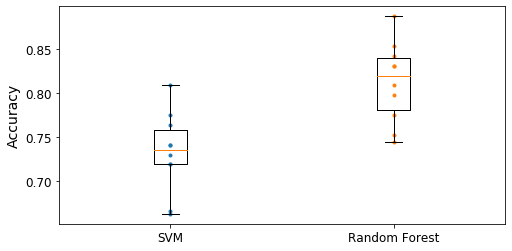

In [ ]:
plt.figure(figsize=(8, 4))
plt.plot([1]*10, svm_scores, ".")
plt.plot([2]*10, forest_scores, ".")
plt.boxplot([svm_scores, forest_scores], labels=("SVM","Random Forest"))
plt.ylabel("Accuracy", fontsize=14)
plt.show()

이 결과를 더 향상시키려면:
* 교차 검증과 그리드 탐색을 사용하여 더 많은 모델을 비교하고 하이퍼파라미터를 튜닝하세요.
* 특성 공학을 더 시도해 보세요, 예를 들면:
  * **SibSp**와 **Parch**을 이 두 특성의 합으로 바꿉니다.
  * **Survived** 특성과 관련된 이름을 구별해 보세요(가령, 이름에 "Countess"가 있는 경우 생존할 가능성이 높습니다).
* 수치 특성을 범주형 특성으로 바꾸어 보세요: 예를 들어, 나이대가 다른 경우 다른 생존 비율을 가질 수 있습니다(아래 참조). 그러므로 나이 구간을 범주로 만들어 나이 대신 사용하는 것이 도움이 될 수 있스니다. 비슷하게 생존자의 30%가 혼자 여행하는 사람이기 때문에 이들을 위한 특별한 범주를 만드는 것이 도움이 될 수 있습니다(아래 참조).

In [ ]:
train_data["AgeBucket"] = train_data["Age"] // 15 * 15
train_data[["AgeBucket", "Survived"]].groupby(['AgeBucket']).mean()

,Survived
AgeBucket,
0.0,0.576923
15.0,0.362745
30.0,0.423256
45.0,0.404494
60.0,0.240000
75.0,1.000000


In [ ]:
train_data["RelativesOnboard"] = train_data["SibSp"] + train_data["Parch"]
train_data[["RelativesOnboard", "Survived"]].groupby(['RelativesOnboard']).mean()

,Survived
RelativesOnboard,
0,0.303538
1,0.552795
2,0.578431
3,0.724138
4,0.200000
5,0.136364
6,0.333333
7,0.000000
10,0.000000


## 4. 스팸 필터

먼저 데이터를 다운받습니다:

In [ ]:
import os
import tarfile
import urllib

DOWNLOAD_ROOT = "http://spamassassin.apache.org/old/publiccorpus/"
HAM_URL = DOWNLOAD_ROOT + "20030228_easy_ham.tar.bz2"
SPAM_URL = DOWNLOAD_ROOT + "20030228_spam.tar.bz2"
SPAM_PATH = os.path.join("datasets", "spam")

def fetch_spam_data(spam_url=SPAM_URL, spam_path=SPAM_PATH):
    if not os.path.isdir(spam_path):
        os.makedirs(spam_path)
    for filename, url in (("ham.tar.bz2", HAM_URL), ("spam.tar.bz2", SPAM_URL)):
        path = os.path.join(spam_path, filename)
        if not os.path.isfile(path):
            urllib.request.urlretrieve(url, path)
        tar_bz2_file = tarfile.open(path)
        tar_bz2_file.extractall(path=SPAM_PATH)
        tar_bz2_file.close()

In [ ]:
fetch_spam_data()

다음, 모든 이메일을 읽어 들입니다:

In [ ]:
HAM_DIR = os.path.join(SPAM_PATH, "easy_ham")
SPAM_DIR = os.path.join(SPAM_PATH, "spam")
ham_filenames = [name for name in sorted(os.listdir(HAM_DIR)) if len(name) > 20]
spam_filenames = [name for name in sorted(os.listdir(SPAM_DIR)) if len(name) > 20]

In [ ]:
len(ham_filenames)

2500

In [ ]:
len(spam_filenames)

500

파이썬의 `email` 모듈을 사용해 이메일을 파싱합니다(헤더, 인코딩 등을 처리합니다):

In [ ]:
import email
import email.policy

def load_email(is_spam, filename, spam_path=SPAM_PATH):
    directory = "spam" if is_spam else "easy_ham"
    with open(os.path.join(spam_path, directory, filename), "rb") as f:
        return email.parser.BytesParser(policy=email.policy.default).parse(f)

In [ ]:
ham_emails = [load_email(is_spam=False, filename=name) for name in ham_filenames]
spam_emails = [load_email(is_spam=True, filename=name) for name in spam_filenames]

데이터가 어떻게 구성되어 있는지 감을 잡기 위해 햄 메일과 스팸 메일을 하나씩 보겠습니다:

In [ ]:
print(ham_emails[1].get_content().strip())

Martin A posted:
Tassos Papadopoulos, the Greek sculptor behind the plan, judged that the
 limestone of Mount Kerdylio, 70 miles east of Salonika and not far from the
 Mount Athos monastic community, was ideal for the patriotic sculpture. 
 
 As well as Alexander's granite features, 240 ft high and 170 ft wide, a
 museum, a restored amphitheatre and car park for admiring crowds are
planned
---------------------
So is this mountain limestone or granite?
If it's limestone, it'll weather pretty fast.

------------------------ Yahoo! Groups Sponsor ---------------------~-->
4 DVDs Free +s&p Join Now
http://us.click.yahoo.com/pt6YBB/NXiEAA/mG3HAA/7gSolB/TM
---------------------------------------------------------------------~->

To unsubscribe from this group, send an email to:
forteana-unsubscribe@egroups.com

 

Your use of Yahoo! Groups is subject to http://docs.yahoo.com/info/terms/


In [ ]:
print(spam_emails[6].get_content().strip())

Help wanted.  We are a 14 year old fortune 500 company, that is
growing at a tremendous rate.  We are looking for individuals who
want to work from home.

This is an opportunity to make an excellent income.  No experience
is required.  We will train you.

So if you are looking to be employed from home with a career that has
vast opportunities, then go:

http://www.basetel.com/wealthnow

We are looking for energetic and self motivated people.  If that is you
than click on the link and fill out the form, and one of our
employement specialist will contact you.

To be removed from our link simple go to:

http://www.basetel.com/remove.html


4139vOLW7-758DoDY1425FRhM1-764SMFc8513fCsLl40


어떤 이메일은 이미지나 첨부 파일을 가진 멀티파트(multipart)입니다(메일에 포함되어 있을수 있습니다). 어떤 파일들이 있는지 살펴 보겠습니다:

In [ ]:
def get_email_structure(email):
    if isinstance(email, str):
        return email
    payload = email.get_payload()
    if isinstance(payload, list):
        return "multipart({})".format(", ".join([
            get_email_structure(sub_email)
            for sub_email in payload
        ]))
    else:
        return email.get_content_type()

In [ ]:
from collections import Counter

def structures_counter(emails):
    structures = Counter()
    for email in emails:
        structure = get_email_structure(email)
        structures[structure] += 1
    return structures

In [ ]:
structures_counter(ham_emails).most_common()

[('text/plain', 2408),
 ('multipart(text/plain, application/pgp-signature)', 66),
 ('multipart(text/plain, text/html)', 8),
 ('multipart(text/plain, text/plain)', 4),
 ('multipart(text/plain)', 3),
 ('multipart(text/plain, application/octet-stream)', 2),
 ('multipart(text/plain, text/enriched)', 1),
 ('multipart(text/plain, application/ms-tnef, text/plain)', 1),
 ('multipart(multipart(text/plain, text/plain, text/plain), application/pgp-signature)',
  1),
 ('multipart(text/plain, video/mng)', 1),
 ('multipart(text/plain, multipart(text/plain))', 1),
 ('multipart(text/plain, application/x-pkcs7-signature)', 1),
 ('multipart(text/plain, multipart(text/plain, text/plain), text/rfc822-headers)',
  1),
 ('multipart(text/plain, multipart(text/plain, text/plain), multipart(multipart(text/plain, application/x-pkcs7-signature)))',
  1),
 ('multipart(text/plain, application/x-java-applet)', 1)]

In [ ]:
structures_counter(spam_emails).most_common()

[('text/plain', 218),
 ('text/html', 183),
 ('multipart(text/plain, text/html)', 45),
 ('multipart(text/html)', 20),
 ('multipart(text/plain)', 19),
 ('multipart(multipart(text/html))', 5),
 ('multipart(text/plain, image/jpeg)', 3),
 ('multipart(text/html, application/octet-stream)', 2),
 ('multipart(text/plain, application/octet-stream)', 1),
 ('multipart(text/html, text/plain)', 1),
 ('multipart(multipart(text/html), application/octet-stream, image/jpeg)', 1),
 ('multipart(multipart(text/plain, text/html), image/gif)', 1),
 ('multipart/alternative', 1)]

햄 메일은 평범한 텍스트가 많고 스팸은 HTML일 경우가 많습니다. 적은 수의 햄 이메일이 PGP로 서명되어 있지만 스팸 메일에는 없습니다. 요약하면 이메일 구조는 유용한 정보입니다.

이제 이메일 헤더를 살펴보겠습니다:

In [ ]:
for header, value in spam_emails[0].items():
    print(header,":",value)

Return-Path : <12a1mailbot1@web.de>
Delivered-To : zzzz@localhost.spamassassin.taint.org
Received : from localhost (localhost [127.0.0.1])	by phobos.labs.spamassassin.taint.org (Postfix) with ESMTP id 136B943C32	for <zzzz@localhost>; Thu, 22 Aug 2002 08:17:21 -0400 (EDT)
Received : from mail.webnote.net [193.120.211.219]	by localhost with POP3 (fetchmail-5.9.0)	for zzzz@localhost (single-drop); Thu, 22 Aug 2002 13:17:21 +0100 (IST)
Received : from dd_it7 ([210.97.77.167])	by webnote.net (8.9.3/8.9.3) with ESMTP id NAA04623	for <zzzz@spamassassin.taint.org>; Thu, 22 Aug 2002 13:09:41 +0100
From : 12a1mailbot1@web.de
Received : from r-smtp.korea.com - 203.122.2.197 by dd_it7  with Microsoft SMTPSVC(5.5.1775.675.6);	 Sat, 24 Aug 2002 09:42:10 +0900
To : dcek1a1@netsgo.com
Subject : Life Insurance - Why Pay More?
Date : Wed, 21 Aug 2002 20:31:57 -1600
MIME-Version : 1.0
Message-ID : <0103c1042001882DD_IT7@dd_it7>
Content-Type : text/html; charset="iso-8859-1"
Content-Transfer-Encoding : qu

보낸사람의 이메일 주소와 같이 헤더에는 유용한 정보가 많이 있지만 여기서는 `Subject` 헤더만 다뤄 보겠습니다:

In [ ]:
spam_emails[0]["Subject"]

'Life Insurance - Why Pay More?'

좋습니다. 데이터에를 더 살펴보기 전에 훈련 세트와 테스트 세트로 나누도록 하겠습니다:

In [ ]:
import numpy as np
from sklearn.model_selection import train_test_split

X = np.array(ham_emails + spam_emails)
y = np.array([0] * len(ham_emails) + [1] * len(spam_emails))

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

이제 전처리 함수를 작성하겠습니다. 먼저 HTML을 일반 텍스트로 변환하는 함수가 필요합니다. 이 작업에는 당연히 [BeautifulSoup](https://www.crummy.com/software/BeautifulSoup/) 라이브러리를 사용하는게 좋지만 의존성을 줄이기 위해서 정규식을 사용하여 대강 만들어 보겠습니다([un̨ho͞ly radiańcé destro҉ying all enli̍̈́̂̈́ghtenment](https://stackoverflow.com/a/1732454/38626)의 위험에도 불구하고). 다음 함수는 `<head>` 섹션을 삭제하고 모든 `<a>` 태그를 HYPERLINK 문자로 바꿉니다. 그런 다음 모든 HTML 태그를 제거하고 텍스트만 남깁니다. 보기 편하게 여러개의 개행 문자를 하나로 만들고 (`&gt;`나 `&nbsp;` 같은) html 엔티티를 복원합니다:

In [ ]:
import re
from html import unescape

def html_to_plain_text(html):
    text = re.sub('<head.*?>.*?</head>', '', html, flags=re.M | re.S | re.I)
    text = re.sub('<a\s.*?>', ' HYPERLINK ', text, flags=re.M | re.S | re.I)
    text = re.sub('<.*?>', '', text, flags=re.M | re.S)
    text = re.sub(r'(\s*\n)+', '\n', text, flags=re.M | re.S)
    return unescape(text)

잘 작동하는지 확인해 보겠습니다. 다음은 HTML 스팸입니다:

In [ ]:
html_spam_emails = [email for email in X_train[y_train==1]
                    if get_email_structure(email) == "text/html"]
sample_html_spam = html_spam_emails[7]
print(sample_html_spam.get_content().strip()[:1000], "...")

<HTML><HEAD><TITLE></TITLE><META http-equiv="Content-Type" content="text/html; charset=windows-1252"><STYLE>A:link {TEX-DECORATION: none}A:active {TEXT-DECORATION: none}A:visited {TEXT-DECORATION: none}A:hover {COLOR: #0033ff; TEXT-DECORATION: underline}</STYLE><META content="MSHTML 6.00.2713.1100" name="GENERATOR"></HEAD>
<BODY text="#000000" vLink="#0033ff" link="#0033ff" bgColor="#CCCC99"><TABLE borderColor="#660000" cellSpacing="0" cellPadding="0" border="0" width="100%"><TR><TD bgColor="#CCCC99" valign="top" colspan="2" height="27">
<font size="6" face="Arial, Helvetica, sans-serif" color="#660000">
<b>OTC</b></font></TD></TR><TR><TD height="2" bgcolor="#6a694f">
<font size="5" face="Times New Roman, Times, serif" color="#FFFFFF">
<b>&nbsp;Newsletter</b></font></TD><TD height="2" bgcolor="#6a694f"><div align="right"><font color="#FFFFFF">
<b>Discover Tomorrow's Winners&nbsp;</b></font></div></TD></TR><TR><TD height="25" colspan="2" bgcolor="#CCCC99"><table width="100%" border="0" 

변환된 텍스트입니다:

In [ ]:
print(html_to_plain_text(sample_html_spam.get_content())[:1000], "...")


OTC
 Newsletter
Discover Tomorrow's Winners 
For Immediate Release
Cal-Bay (Stock Symbol: CBYI)
Watch for analyst "Strong Buy Recommendations" and several advisory newsletters picking CBYI.  CBYI has filed to be traded on the OTCBB, share prices historically INCREASE when companies get listed on this larger trading exchange. CBYI is trading around 25 cents and should skyrocket to $2.66 - $3.25 a share in the near future.
Put CBYI on your watch list, acquire a position TODAY.
REASONS TO INVEST IN CBYI
A profitable company and is on track to beat ALL earnings estimates!
One of the FASTEST growing distributors in environmental & safety equipment instruments.
Excellent management team, several EXCLUSIVE contracts.  IMPRESSIVE client list including the U.S. Air Force, Anheuser-Busch, Chevron Refining and Mitsubishi Heavy Industries, GE-Energy & Environmental Research.
RAPIDLY GROWING INDUSTRY
Industry revenues exceed $900 million, estimates indicate that there could be as much as $25 billi

아주 좋습니다! 이제 포맷에 상관없이 이메일을 입력으로 받아서 일반 텍스트를 출력하는 함수를 만들겠습니다:

In [ ]:
def email_to_text(email):
    html = None
    for part in email.walk():
        ctype = part.get_content_type()
        if not ctype in ("text/plain", "text/html"):
            continue
        try:
            content = part.get_content()
        except: # in case of encoding issues
            content = str(part.get_payload())
        if ctype == "text/plain":
            return content
        else:
            html = content
    if html:
        return html_to_plain_text(html)

In [ ]:
print(email_to_text(sample_html_spam)[:100], "...")


OTC
 Newsletter
Discover Tomorrow's Winners 
For Immediate Release
Cal-Bay (Stock Symbol: CBYI)
Wat ...


어간 추출을 해보죠! 이 작업을 하려면 자연어 처리 툴킷([NLTK](http://www.nltk.org/))을 설치해야 합니다. 다음 명령으로 간단히 설치할 수 있습니다(먼저 virtualenv 환경을 활성화시켜야 합니다. 별도의 환경이 없다면 어드민 권한이 필요할지 모릅니다. 아니면 `--user` 옵션을 사용하세요):

`$ pip install nltk`

In [ ]:
try:
    import nltk

    stemmer = nltk.PorterStemmer()
    for word in ("Computations", "Computation", "Computing", "Computed", "Compute", "Compulsive"):
        print(word, "=>", stemmer.stem(word))
except ImportError:
    print("Error: stemming requires the NLTK module.")
    stemmer = None

Computations => comput
Computation => comput
Computing => comput
Computed => comput
Compute => comput
Compulsive => compuls


인터넷 주소는 "URL" 문자로 바꾸겠습니다. [정규식](https://mathiasbynens.be/demo/url-regex)을 하드 코딩할 수도 있지만 [urlextract](https://github.com/lipoja/URLExtract) 라이브러리를 사용하겠습니다. 다음 명령으로 설치합니다(먼저 virtualenv 환경을 활성화시켜야 합니다. 별도의 환경이 없다면 어드민 권한이 필요할지 모릅니다. 아니면 `--user` 옵션을 사용하세요):

`$ pip install urlextract`

In [ ]:
# 코랩에서 이 노트북을 실행하려면 먼저 pip install urlextract을 실행합니다
try:
    import google.colab
    !pip install -q -U urlextract
except ImportError:
    pass # not running on Colab

In [ ]:
try:
    import urlextract # 루트 도메인 이름을 다운로드하기 위해 인터넷 연결이 필요할지 모릅니다
    
    url_extractor = urlextract.URLExtract()
    print(url_extractor.find_urls("Will it detect github.com and https://youtu.be/7Pq-S557XQU?t=3m32s"))
except ImportError:
    print("Error: replacing URLs requires the urlextract module.")
    url_extractor = None

['github.com', 'https://youtu.be/7Pq-S557XQU?t=3m32s']


이들을 모두 하나의 변환기로 연결하여 이메일을 단어 카운트로 바꿀 것입니다. 파이썬의 `split()` 메서드를 사용하면 구둣점과 단어 경계를 기준으로 문장을 단어로 바꿉니다. 이 방법이 많은 언어에 통하지만 전부는 아닙니다. 예를 들어 중국어와 일본어는 일반적으로 단어 사이에 공백을 두지 않습니다. 베트남어는 음절 사이에 공백을 두기도 합니다. 여기서는 데이터셋이 (거의) 영어로 되어 있기 때문에 문제없습니다.

In [ ]:
from sklearn.base import BaseEstimator, TransformerMixin

class EmailToWordCounterTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, strip_headers=True, lower_case=True, remove_punctuation=True,
                 replace_urls=True, replace_numbers=True, stemming=True):
        self.strip_headers = strip_headers
        self.lower_case = lower_case
        self.remove_punctuation = remove_punctuation
        self.replace_urls = replace_urls
        self.replace_numbers = replace_numbers
        self.stemming = stemming
    def fit(self, X, y=None):
        return self
    def transform(self, X, y=None):
        X_transformed = []
        for email in X:
            text = email_to_text(email) or ""
            if self.lower_case:
                text = text.lower()
            if self.replace_urls and url_extractor is not None:
                urls = list(set(url_extractor.find_urls(text)))
                urls.sort(key=lambda url: len(url), reverse=True)
                for url in urls:
                    text = text.replace(url, " URL ")
            if self.replace_numbers:
                text = re.sub(r'\d+(?:\.\d*(?:[eE]\d+))?', 'NUMBER', text)
            if self.remove_punctuation:
                text = re.sub(r'\W+', ' ', text, flags=re.M)
            word_counts = Counter(text.split())
            if self.stemming and stemmer is not None:
                stemmed_word_counts = Counter()
                for word, count in word_counts.items():
                    stemmed_word = stemmer.stem(word)
                    stemmed_word_counts[stemmed_word] += count
                word_counts = stemmed_word_counts
            X_transformed.append(word_counts)
        return np.array(X_transformed)

이 변환기를 몇 개의 이메일에 적용해 보겠습니다:

In [ ]:
X_few = X_train[:3]
X_few_wordcounts = EmailToWordCounterTransformer().fit_transform(X_few)
X_few_wordcounts

array([Counter({'chuck': 1, 'murcko': 1, 'wrote': 1, 'stuff': 1, 'yawn': 1, 'r': 1}),
       Counter({'the': 11, 'of': 9, 'and': 8, 'all': 3, 'christian': 3, 'to': 3, 'by': 3, 'jefferson': 2, 'i': 2, 'have': 2, 'superstit': 2, 'one': 2, 'on': 2, 'been': 2, 'ha': 2, 'half': 2, 'rogueri': 2, 'teach': 2, 'jesu': 2, 'some': 1, 'interest': 1, 'quot': 1, 'url': 1, 'thoma': 1, 'examin': 1, 'known': 1, 'word': 1, 'do': 1, 'not': 1, 'find': 1, 'in': 1, 'our': 1, 'particular': 1, 'redeem': 1, 'featur': 1, 'they': 1, 'are': 1, 'alik': 1, 'found': 1, 'fabl': 1, 'mytholog': 1, 'million': 1, 'innoc': 1, 'men': 1, 'women': 1, 'children': 1, 'sinc': 1, 'introduct': 1, 'burnt': 1, 'tortur': 1, 'fine': 1, 'imprison': 1, 'what': 1, 'effect': 1, 'thi': 1, 'coercion': 1, 'make': 1, 'world': 1, 'fool': 1, 'other': 1, 'hypocrit': 1, 'support': 1, 'error': 1, 'over': 1, 'earth': 1, 'six': 1, 'histor': 1, 'american': 1, 'john': 1, 'e': 1, 'remsburg': 1, 'letter': 1, 'william': 1, 'short': 1, 'again': 1, 'becom

제대로 작동하는 것 같네요!

이제 단어 카운트를 벡터로 변환해야 합니다. 이를 위해서 또 다른 변환기를 만들겠습니다. 이 변환기는 (자주 나타나는 단어 순으로 정렬된) 어휘 목록을 구축하는 `fit()` 메서드와 어휘 목록을 사용해 단어를 벡터로 바꾸는 `transform()` 메서드를 가집니다. 출력은 희소 행렬이 됩니다.

In [ ]:
from scipy.sparse import csr_matrix

class WordCounterToVectorTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, vocabulary_size=1000):
        self.vocabulary_size = vocabulary_size
    def fit(self, X, y=None):
        total_count = Counter()
        for word_count in X:
            for word, count in word_count.items():
                total_count[word] += min(count, 10)
        most_common = total_count.most_common()[:self.vocabulary_size]
        self.most_common_ = most_common
        self.vocabulary_ = {word: index + 1 for index, (word, count) in enumerate(most_common)}
        return self
    def transform(self, X, y=None):
        rows = []
        cols = []
        data = []
        for row, word_count in enumerate(X):
            for word, count in word_count.items():
                rows.append(row)
                cols.append(self.vocabulary_.get(word, 0))
                data.append(count)
        return csr_matrix((data, (rows, cols)), shape=(len(X), self.vocabulary_size + 1))

In [ ]:
vocab_transformer = WordCounterToVectorTransformer(vocabulary_size=10)
X_few_vectors = vocab_transformer.fit_transform(X_few_wordcounts)
X_few_vectors

<3x11 sparse matrix of type '<class 'numpy.longlong'>'
	with 20 stored elements in Compressed Sparse Row format>

In [ ]:
X_few_vectors.toarray()

array([[ 6,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
       [99, 11,  9,  8,  3,  1,  3,  1,  3,  2,  3],
       [67,  0,  1,  2,  3,  4,  1,  2,  0,  1,  0]], dtype=int64)

이 행렬은 무엇을 의미하나요? 세 번째 행의 첫 번째 열의 65는 세 번째 이메일이 어휘 목록에 없는 단어를 65개 가지고 있다는 뜻입니다. 그 다음의 0은 어휘 목록에 있는 첫 번째 단어가 한 번도 등장하지 않는다는 뜻이고 그 다음의 1은 한 번 나타난다는 뜻입니다. 이 단어들이 무엇인지 확인하려면 어휘 목록을 보면 됩니다. 첫 번째 단어는 "the"이고 두 번째 단어는 "of"입니다.

In [ ]:
vocab_transformer.vocabulary_

{'the': 1,
 'of': 2,
 'and': 3,
 'to': 4,
 'url': 5,
 'all': 6,
 'in': 7,
 'christian': 8,
 'on': 9,
 'by': 10}

이제 스팸 분류기를 훈련시킬 준비를 마쳤습니다! 전체 데이터셋을 변환시켜보죠:

In [ ]:
from sklearn.pipeline import Pipeline

preprocess_pipeline = Pipeline([
    ("email_to_wordcount", EmailToWordCounterTransformer()),
    ("wordcount_to_vector", WordCounterToVectorTransformer()),
])

X_train_transformed = preprocess_pipeline.fit_transform(X_train)

**Note**: to be future-proof, we set `solver="lbfgs"` since this will be the default value in Scikit-Learn 0.22.

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score

log_clf = LogisticRegression(solver="lbfgs", random_state=42)
score = cross_val_score(log_clf, X_train_transformed, y_train, cv=3, verbose=3)
score.mean()

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
/home/haesun/anaconda3/envs/homl2/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
/home/haesun/anaconda3/envs/homl2/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https

[CV]  ................................................................
[CV] .................................... , score=0.981, total=   0.1s
[CV]  ................................................................
[CV] .................................... , score=0.985, total=   0.1s
[CV]  ................................................................
[CV] .................................... , score=0.990, total=   0.1s


/home/haesun/anaconda3/envs/homl2/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.2s finished


0.9854166666666666

98.7%가 넘네요. 첫 번째 시도치고 나쁘지 않습니다! :) 그러나 이 데이터셋은 비교적 쉬운 문제입니다. 더 어려운 데이터셋에 적용해 보면 결과가 그리 높지 않을 것입니다. 여러개의 모델을 시도해 보고 제일 좋은 것을 골라 교차 검증으로 세밀하게 튜닝해 보세요.

하지만 전체 내용을 파악했으므로 여기서 멈추겠습니다. 테스트 세트에서 정밀도/재현율을 출력해 보겠습니다:

In [ ]:
from sklearn.metrics import precision_score, recall_score

X_test_transformed = preprocess_pipeline.transform(X_test)

log_clf = LogisticRegression(solver="lbfgs", random_state=42)
log_clf.fit(X_train_transformed, y_train)

y_pred = log_clf.predict(X_test_transformed)

print("정밀도: {:.2f}%".format(100 * precision_score(y_test, y_pred)))
print("재현율: {:.2f}%".format(100 * recall_score(y_test, y_pred)))

정밀도: 95.88%
재현율: 97.89%


/home/haesun/anaconda3/envs/homl2/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
